##      Analysis and Forecast of a city's Bike Rental Demand using Multiple Regression and   Random Forest Model

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import datetime as dt

# this allows plots to appear directly in the notebook
%matplotlib inline

### Importing Data

In [11]:
bike_data = pd.read_csv("C:\Users\Murtaza\Desktop\SCU NOTES\Python\python final project\data files\datafile.csv")

In [12]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Data Cleaning

In [13]:
# Splitting datetime column into Date and Time column
bike_data['Date'], bike_data['Time'] = zip(*bike_data['datetime'].str.split())
bike_data =bike_data.drop('datetime',axis=1)

In [14]:
#Extracting Day of the WEEK,Month and Year from the Date column
weekdays = bike_data['Date'].apply(lambda x : dt.datetime.strptime(x, '%Y-%m-%d').weekday())
bike_data['Weekday']= bike_data['Date'].apply(lambda x : dt.datetime.strptime(x, '%Y-%m-%d').strftime('%A'))
bike_data['Year'] = bike_data['Date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').strftime('%Y'))
bike_data[['Year']] = bike_data[['Year']].astype(int)
bike_data['Month'] = bike_data['Date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').strftime('%m'))
bike_data[['Month']] = bike_data[['Month']].astype(int)
bike_data['Date'] = bike_data['Date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').strftime('%d'))
bike_data[['Date']] = bike_data[['Date']].astype(int)

In [15]:
# Converting Time column into an integer for easier analysis
bike_data['Time']= bike_data['Time'].apply(lambda x : dt.datetime.strptime(x, '%H:%M:%S').strftime('%H'))
bike_data[['Time']] = bike_data[['Time']].astype(int)

# Created a new feature days having categories like “weekday”, “weekend” and “holiday”
day_type =[]
for index,row in bike_data.iterrows():
    if row['holiday'] == 0 and row['workingday'] == 0:
        day_type.append('Weekend')
        
    elif row['holiday'] == 0 and row['workingday'] == 1:
        day_type.append('WorkingDay')
        
    elif row['holiday'] == 1 and row['workingday'] == 0:
        day_type.append('Holiday')
bike_data['day_type']=day_type

#Dropping columns Holiday and workingday because of the new feature day_type created
bike_data = bike_data.drop(['holiday','workingday'],axis=1)

#Converting temperature and atemperature from float to integer
bike_data[['temp','atemp']] = bike_data[['temp','atemp']].astype(int)

#Creating copy of original dataframe for random forest model
bike_data3 = bike_data.copy()

#Filling coded values of season with their actual values
bike_data['season']= bike_data['season'].replace({1:'spring',2:'summer',3:'fall',4:'winter'})

#Filling coded values of weather with their actual values
bike_data['weather'] =  bike_data['weather'].replace({1:'Clear',2:'Misty',3:'LightRain',4:'HeavyRain'})

#Creating copy of original dataframe for regression analysis
bike_data2 =bike_data.copy()
bike_data2.head()

,season,weather,temp,atemp,humidity,windspeed,casual,registered,count,Date,Time,Weekday,Year,Month,day_type
0,spring,Clear,9,14,81,0.0,3,13,16,1,0,Saturday,2011,1,Weekend
1,spring,Clear,9,13,80,0.0,8,32,40,1,1,Saturday,2011,1,Weekend
2,spring,Clear,9,13,80,0.0,5,27,32,1,2,Saturday,2011,1,Weekend
3,spring,Clear,9,14,75,0.0,3,10,13,1,3,Saturday,2011,1,Weekend
4,spring,Clear,9,14,75,0.0,0,1,1,1,4,Saturday,2011,1,Weekend


### Visualisation Of Features 

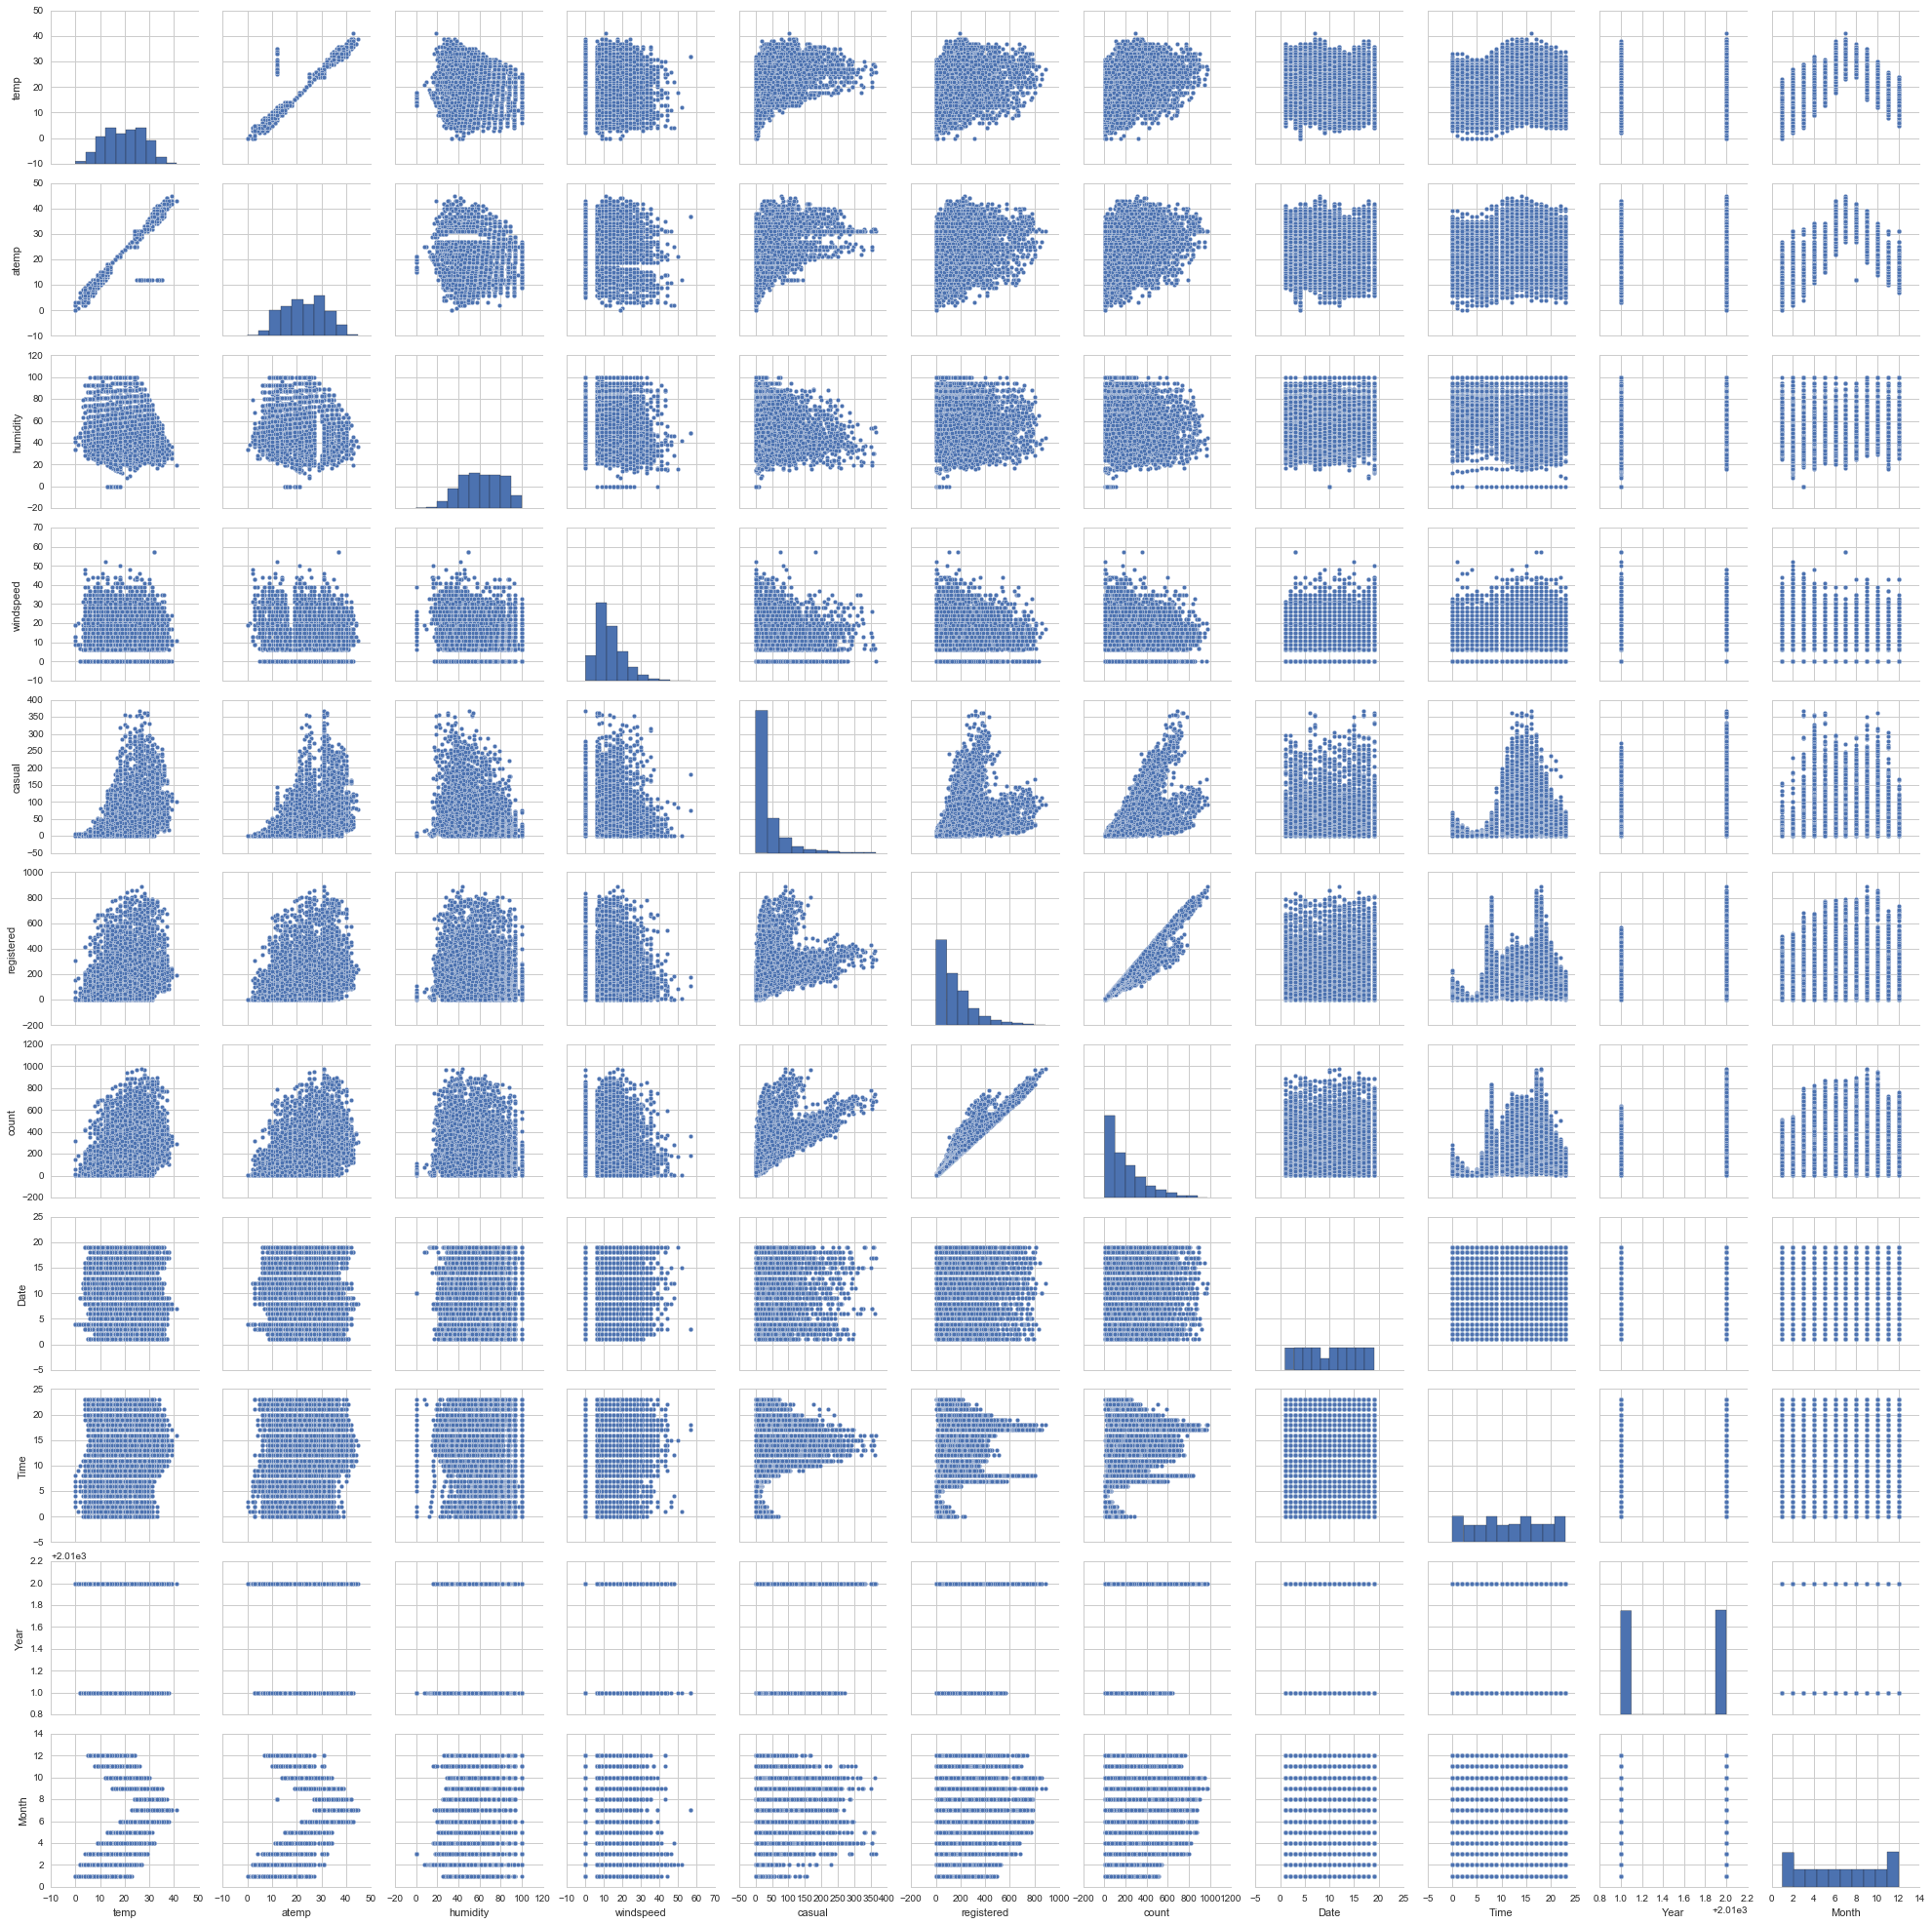

In [17]:
sns.pairplot()

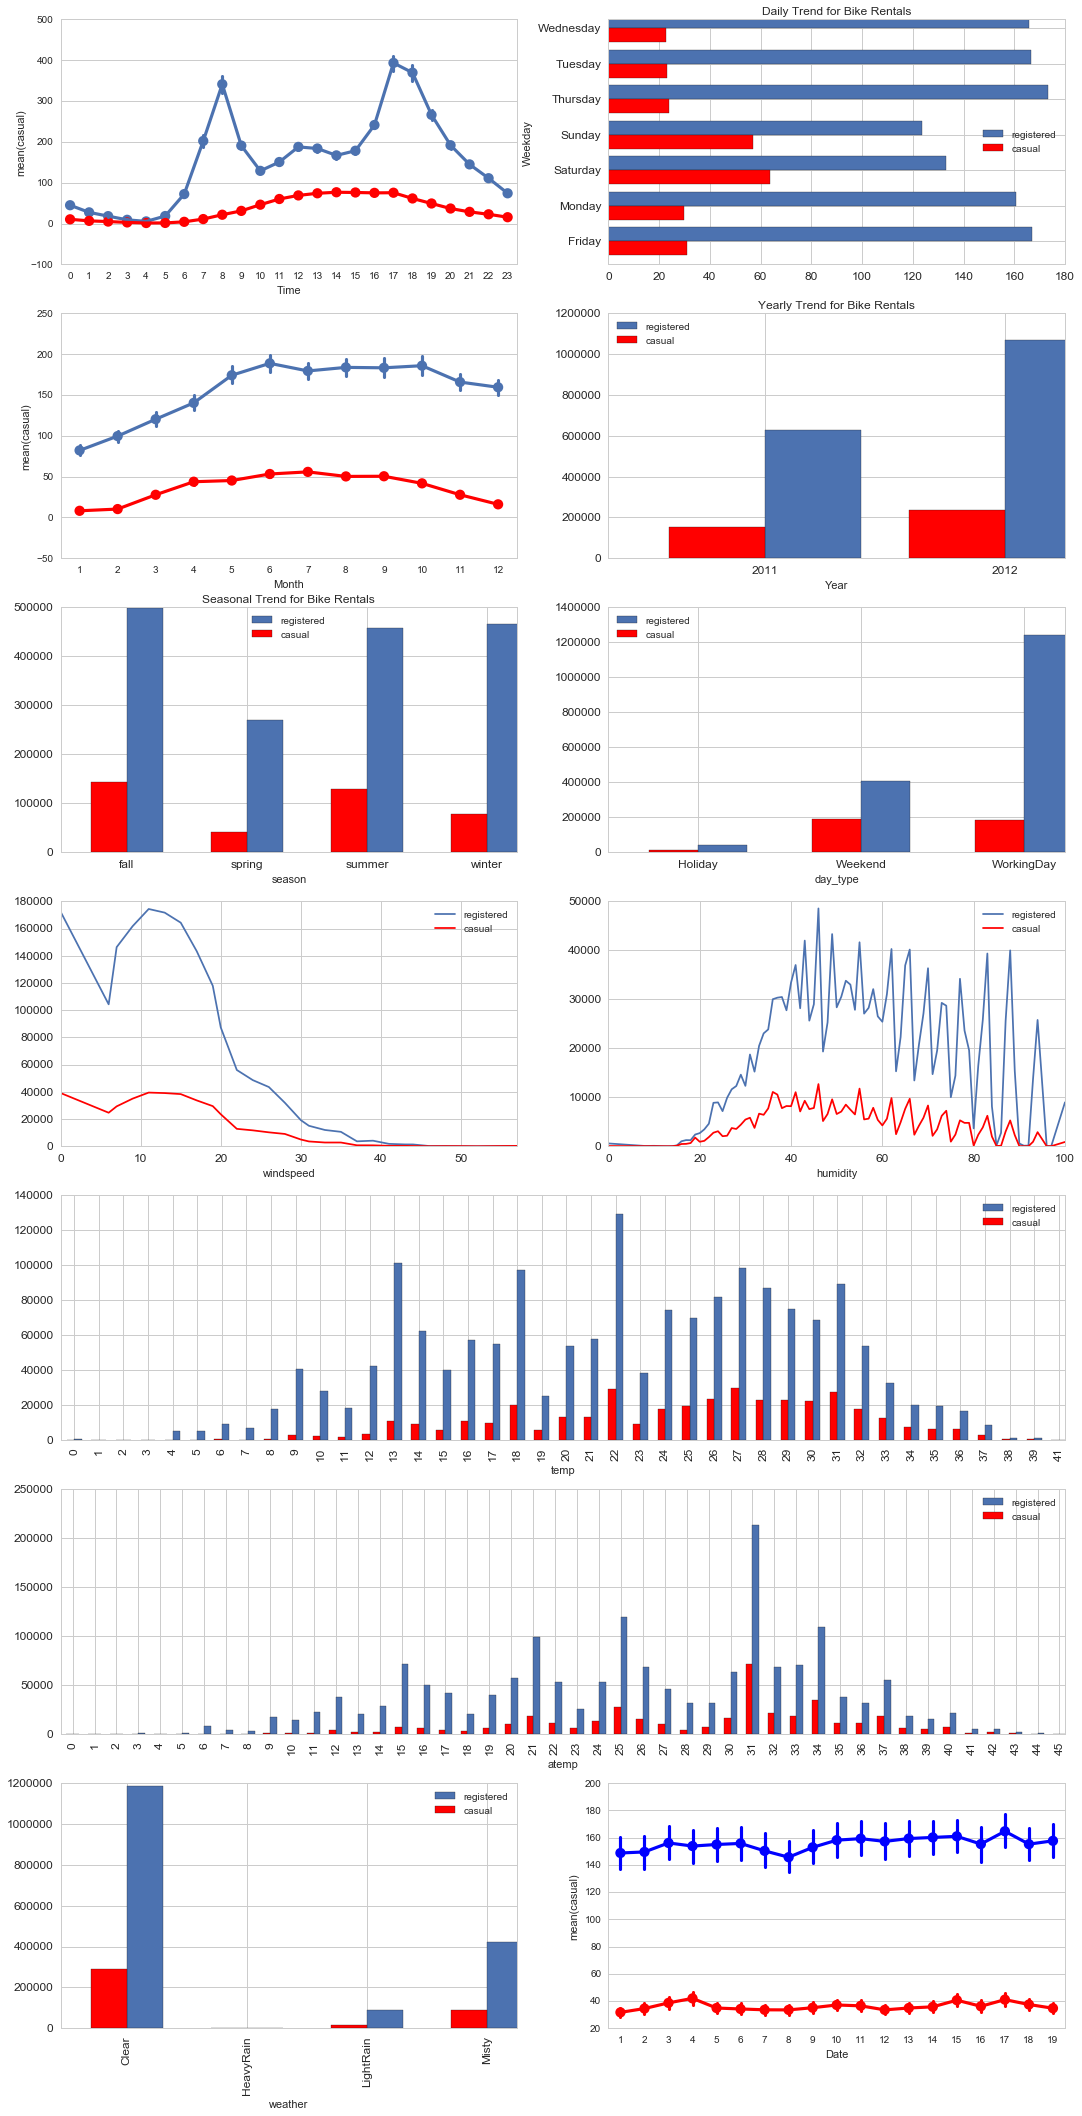

In [428]:
# visualise hourly demand trend for registered and casual users
#fig, axis = plt.subplots(6,2)
fig = plt.figure()
fig.set_size_inches (18,36)
fig.add_subplot(7,2,1)
sns.pointplot(x ='Time',y ='registered',data=bike_data2)
sns.pointplot(x = 'Time', y = 'casual',data=bike_data2,color ='red')
# visualise daily demand trend for registered and casual users
ax1 = fig.add_subplot(7,2,2)
bike_data2.groupby('Weekday')[['registered']].mean().plot(kind='barh',ax=ax1,width =0.4,fontsize=12,
                                                          title ='Daily Trend for Bike Rentals',position=0)
bike_data2.groupby('Weekday')[['casual']].mean().plot(kind='barh',ax=ax1,width =0.4,fontsize=12,
                                                      title ='Daily Trend for Bike Rentals',color ='red',position=1)
## visualise monthly demand trend for registered and casual users
fig.add_subplot(7,2,3)
sns.pointplot(x='Month',y='registered',data=bike_data2)
sns.pointplot(x='Month',y='casual',data=bike_data2,color ='red')
#visualise yearly demand trend for registered and casual users
ax2 = fig.add_subplot(7,2,4)
bike_data2.groupby('Year')[['registered']].sum().plot(kind='bar',ax=ax2,width=0.4,fontsize=12,
                                                      title ='Yearly Trend for Bike Rentals',position=0,rot = 0)
bike_data2.groupby('Year')[['casual']].sum().plot(kind='bar',ax=ax2,width=0.4,fontsize=12,
                                                  title ='Yearly Trend for Bike Rentals',position =1,color='red',rot=0)
#visualise seasonal demand trend for registered and casual users
ax3 =fig.add_subplot(7,2,5)
bike_data2.groupby('season')[['registered']].sum().plot(kind='bar',ax=ax3,width =0.3,fontsize=12,
                                                        title ='Seasonal Trend for Bike Rentals',position = 0,rot=0)
bike_data2.groupby('season')[['casual']].sum().plot(kind='bar',ax=ax3,width =0.3,fontsize=12,
                                                    title ='Seasonal Trend for Bike Rentals',position =1,color ='red',rot=0)

#visualise relationship between type of day and demand  for registered and casual users
ax4 = fig.add_subplot(7,2,6)
bike_data2.groupby('day_type')[['registered']].sum().plot(kind='bar',fontsize=12,ax=ax4,position=0,rot = 0,width = 0.3)
bike_data2.groupby('day_type')[['casual']].sum().plot(kind='bar',fontsize=12,color='red',ax=ax4,position=1,rot=0,width =0.3)

#visualise relationship between temperature and demand  for registered and casual users
ax5 = fig.add_subplot(7,1,5)
bike_data2.groupby('temp')[['registered']].sum().plot(kind='bar',fontsize=12,ax=ax5,position=0,width = 0.3)
bike_data2.groupby('temp')[['casual']].sum().plot(kind='bar',fontsize=12,color='red',ax=ax5,position=1,width =0.3)

#visualise relationship between feeling temperature and demand  for registered and casual users
ax5 = fig.add_subplot(7,1,6)
bike_data2.groupby('atemp')[['registered']].sum().plot(kind='bar',fontsize=12,ax=ax5,position=0,width = 0.3)
bike_data2.groupby('atemp')[['casual']].sum().plot(kind='bar',fontsize=12,color='red',ax=ax5,position=1,width =0.3)

#visualise relationship between windspeed and demand  for registered and casual users
ax6 = fig.add_subplot(7,2,7)
bike_data2.groupby('windspeed')[['registered']].sum().plot(kind='line',fontsize=12,ax=ax6)
bike_data2.groupby('windspeed')[['casual']].sum().plot(kind='line',fontsize=12,color='red',ax=ax6)


#visualise relationship between humidity and demand  for registered and casual users
ax6 = fig.add_subplot(7,2,8)
bike_data2.groupby('humidity')[['registered']].sum().plot(kind='line',fontsize=12,ax=ax6)
bike_data2.groupby('humidity')[['casual']].sum().plot(kind='line',fontsize=12,color='red',ax=ax6)

##visualise relationship between weather and demand  for registered and casual users
ax5 = fig.add_subplot(7,2,13)
bike_data2.groupby('weather')[['registered']].sum().plot(kind='bar',fontsize=12,ax=ax5,position=0,width = 0.3)
bike_data2.groupby('weather')[['casual']].sum().plot(kind='bar',fontsize=12,color='red',ax=ax5,position=1,width =0.3)

##visualise relationship between weather and demand  for registered and casual users
ax5 = fig.add_subplot(7,2,14)
sns.pointplot(x = 'Date',y='registered',data=bike_data2,color ='blue')
sns.pointplot(x = 'Date',y='casual',data=bike_data2,color ='red')

In [ ]:
sns.pairplot()

### Feature Engineering

#### Binning of Continous Variable features, using Decision Tree, to turn them into Categorical Variable 

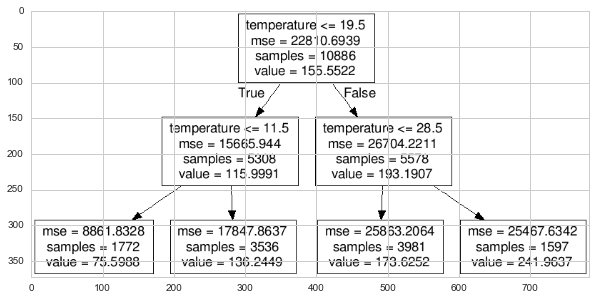

In [430]:
# Binning of temperature variable for registered users
from sklearn import tree
from pandas import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
Y= bike_data2['registered']
X = bike_data2['temp']
z = X.reshape(-1,1)
model = tree.DecisionTreeRegressor(min_samples_split = 500,max_depth = 2)
clf = model.fit(z,Y)
dotfile = open("dtree2.dot",'w')
tree.export_graphviz(clf, out_file = dotfile)
dotfile.close()

#Converted the dot file into an image through an online interface(http://sandbox.kidstrythisathome.com/erdos/)
#and opened the image in the notebook (was not able to convert the dot file into png using pyhton)
fig,ax = plt.subplots(figsize=(10, 6))
img = mpimg.imread('dtree2.png')
ax.imshow(img)

In [431]:
# Using Nodes of the decision tree, creating bins for the temperature variable
temp_reg =[]
for index,row in bike_data2.iterrows():
    if row['temp'] <= 12 :
        temp_reg.append(1)
        
    elif 12 < row['temp'] <= 20 :
        temp_reg.append(2)
        
    elif 20 < row['temp'] <= 29:
        temp_reg.append(3)
    
    elif row['temp'] > 29:
        temp_reg.append(4)
# Creating new variable temp_reg     
bike_data2['temp_reg']=temp_reg
#bike_data3['temp_reg']=temp_reg

In [432]:
# Binning of temperature variable for casual users
from sklearn import tree
from pandas import *
Y= bike_data2['casual']
X = bike_data2['temp']
z = X.reshape(-1,1)
model = tree.DecisionTreeRegressor(min_samples_split = 500,max_depth = 2)
clf = model.fit(z,Y)
dot1file = open("C:\Users\Murtaza\Desktop\dtree2.dot",'w')
tree.export_graphviz(clf, out_file = dot1file)
dot1file.close()

# Using Nodes of the decision tree, creating bins for the temperature variable
temp_cas =[]
for index,row in bike_data2.iterrows():
    if row['temp'] <= 15:
        temp_cas.append(1)
        
    elif 15 < row['temp'] <= 23:
        temp_cas.append(2)
        
    elif 23 < row['temp'] <= 30:
        temp_cas.append(3)
    
    elif row['temp'] > 30:
        temp_cas.append(4)
# Creating new variable temp_cas    
bike_data2['temp_cas']=temp_cas
#bike_data3['temp_cas']=temp_cas

### Correlation between the features

In [19]:
def highlight_corr(val):
    """
    Takes a scalar and returns a string with
    the css property `'background-color:yellow'` for high correlation.
    """
    color = 'yellow' if 0.7< val < 1 else ''
    return 'background-color: %s' % color

In [20]:
bike_corr=bike_data[['temp','atemp','windspeed','humidity','casual','registered']].corr()
bike_corr.style.applymap(highlight_corr)

##### As correlation is very high between temperature and feeling temperature , I will not include feeling temperature feature in my regression model

### Creating Dummy Variables For Categorical Features for Regression Model

In [399]:
# create  dummy variables for season using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.season, prefix='Season').iloc[:, 1:])
# drop season variable
bike_data2= bike_data2.drop('season', axis=1)

In [400]:
# create  dummy variables for days using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.day_type, prefix='day_type').iloc[:, 1:])
# drop days variable
bike_data2= bike_data2.drop('day_type', axis=1)

In [401]:
# create  dummy variables for weather using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.weather, prefix='weather').iloc[:, 1:])
# drop weather variable
bike_data2= bike_data2.drop('weather', axis=1)

In [402]:
# create  dummy variables for Time using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.Time, prefix='Time').iloc[:, 1:])
# drop Time1 variable
bike_data2= bike_data2.drop('Time', axis=1)

In [403]:
# create  dummy variables for Weekday using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.Weekday, prefix='Weekday').iloc[:, 1:])
# drop Weekday variable
bike_data2= bike_data2.drop('Weekday', axis=1)

In [404]:
# create  dummy variables for Year using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.Year, prefix='Year').iloc[:, 1:])
# drop Year variable
bike_data2= bike_data2.drop('Year', axis=1)

In [405]:
# create  dummy variables for Month using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.Month, prefix='Month').iloc[:, 1:])
# drop Month variable
bike_data2= bike_data2.drop('Month', axis=1)

In [406]:
# create  dummy variables for temp_reg using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.temp_reg, prefix='temp_reg').iloc[:, 1:])
# drop temp_reg variable
bike_data2= bike_data2.drop('temp_reg', axis=1)

In [407]:
# create  dummy variables for temp_cas using get_dummies, then exclude the first dummy column
bike_data2= bike_data2.join(pd.get_dummies(bike_data2.temp_cas, prefix='temp_cas').iloc[:, 1:])
# drop temp_cas,tempearture and atemperature variable
bike_data2= bike_data2.drop(['temp_cas','temp','atemp'], axis=1)

### Creating Test and Training Dataset

### Splitting Dataframe into  Test and Training Dataset for Regression Model

In [408]:
#Creating Training Dataset for predicting registered users hourly demand
train_reg_X = bike_data2.loc[ bike_data2['Date'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14])]
train_reg_Y = train_reg_X['registered']
train_reg_X = train_reg_X.drop(['count','casual','registered','Date','temp_cas_2','temp_cas_3','temp_cas_4'],axis=1)

##As there are natural outliers,so we'll be predicting log of dependant variable,thus converting registered users 
## demand values into log values
from math import log
train_reg_Y_log= np.log(train_reg_Y)
from numpy import inf
train_reg_Y_log[train_reg_Y_log == -inf] = 0 

#Creating Test Dataset for predicting registered users hourly demand
test_data = bike_data2.loc[ bike_data2['Date'].isin([15,16,17,18,19])]
test_reg_X = test_data.drop(['registered','casual','count','temp_cas_2','temp_cas_3','temp_cas_4','Date'],axis=1)
test_reg_Y = test_data['registered']
#Taking log
test_reg_Y_log= np.log(test_reg_Y)
test_reg_Y_log[test_reg_Y_log == -inf] = 0

In [409]:
#Creating Training Dataset for predicting casual users hourly demand
train_cas_X = bike_data2.loc[ bike_data2['Date'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14])]
train_cas_Y = train_cas_X['casual']
train_cas_X = train_cas_X.drop(['count','casual','registered','Date','temp_reg_2','temp_reg_3','temp_reg_4'],axis=1)


##As there are natural outliers,so we'll be predicting log of dependant variable,thus converting casual users 
#demand values into log values
train_cas_Y_log = np.log(train_cas_Y)
train_cas_Y_log[train_cas_Y_log == -inf] = 0 

#Creating Test Dataset for predicting casual users hourly demand
test_cas_X = test_data.drop(['registered','casual','count','temp_reg_2','temp_reg_3','temp_reg_4','Date'],axis=1)
test_cas_Y = test_data['casual']
##Taking log 
test_cas_Y_log= np.log (test_cas_Y)
test_cas_Y_log[test_cas_Y_log== -inf] = 0

### Splitting Dataframe into  Test and Training Dataset for Random Forest Model

In [410]:
# Factoring dtype: object columns 
bike_data3['Weekdays'] = weekdays
columns = ['Year','day_type']
bike_data3[columns] = bike_data3[columns].apply(lambda x: x.astype('category'))
bike_data3[columns] = bike_data3[columns].apply(lambda x: x.cat.codes)
bike_data3 = bike_data3.drop('Weekday',axis=1)

In [411]:
#Creating Training Dataset for predicting registered users hourly demand
train_reg_X2 = bike_data3.loc[ bike_data3['Date'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14])]
train_reg_Y2 = train_reg_X2['registered']
train_reg_X2 = train_reg_X2.drop(['count','casual','registered','Date'],axis=1)

##As there are natural outliers,so we'll be predicting log of dependant variable,thus converting registered users 
## demand values into log values
from math import log
train_reg_Y_log2= np.log(train_reg_Y2)
from numpy import inf
train_reg_Y_log2[train_reg_Y_log2 == -inf] = 0 

#Creating Test Dataset for predicting registered users hourly demand
test_data2 = bike_data3.loc[ bike_data3['Date'].isin([15,16,17,18,19])]
test_reg_X2 = test_data2.drop(['registered','casual','count','Date'],axis=1)
test_reg_Y2 = test_data2['registered']
#Taking log
test_reg_Y_log2= np.log(test_reg_Y2)
test_reg_Y_log2[test_reg_Y_log2 == -inf] = 0

In [412]:
#Creating Training Dataset for predicting casual users hourly demand
train_cas_X2 = bike_data3.loc[ bike_data3['Date'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14])]
train_cas_Y2 = train_cas_X2['casual']
train_cas_X2 = train_cas_X2.drop(['count','casual','registered','Date'],axis=1)


##As there are natural outliers,so we'll be predicting log of dependant variable,thus converting casual users 
#demand values into log values
train_cas_Y_log2 = np.log(train_cas_Y2)
train_cas_Y_log2[train_cas_Y_log2 == -inf] = 0
#Creating Test Dataset for predicting casual users hourly demand
test_cas_X2 = test_data2.drop(['registered','casual','count','Date'],axis=1)
test_cas_Y2 = test_data2['casual']
##Taking log 
test_cas_Y_log2= np.log (test_cas_Y2)
test_cas_Y_log2[test_cas_Y_log2 == -inf] = 0

##  Multiple Regression Model 

### Model building for casual users

In [420]:
feature_cols =list(train_cas_X.columns.values)
# create X and y
X = train_cas_X
y = train_cas_Y_log

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm_cas= LinearRegression()
lm_cas.fit(X,y)

#Predicting log casual user demand through the model.
lm_cas_predict = lm_cas.predict(test_cas_X)

# R square
lm_cas.score(test_cas_X,test_cas_Y_log)

#use below to see the coefficients
#zip(feature_cols, lm_cas.coef_)

0.81500935161133048

### Model building for registered users

In [419]:
feature_cols2 = list(train_reg_X2.columns.values)
# create X and y
X = train_reg_X
y = train_reg_Y_log

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm_reg= LinearRegression()
lm_reg.fit(X,y)

#Predicting log registered user demand through the model.
lm_reg_predict = lm_reg.predict(test_reg_X)

# R square
lm_reg.score(test_reg_X,test_reg_Y_log)

#use below to see the coefficients
#zip(feature_cols2, lm_reg.coef_)

0.81787680405496843

## Random Forest Model

### Model for Registered Users

In [415]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(train_reg_X2,train_reg_Y_log2)

rf_predict_reg = rf_reg.predict(test_reg_X2)

#R square
rf_reg.score(test_reg_X2,test_reg_Y_log2)

0.94458620779178226

### Feature Importance for Registered Users

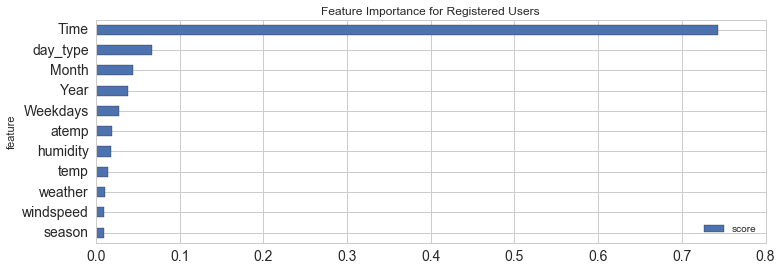

In [416]:
names = train_reg_X2.columns.values
feature_importance_reg =  sorted(zip(map(lambda x: round(x, 4), rf_reg.feature_importances_), names), reverse=False)
feature_importance_reg = pd.DataFrame(feature_importance_reg,columns=['score','feature'])
feature_importance_reg.plot(kind='barh',x='feature',y='score',figsize =(12,4),title='Feature Importance for Registered Users',fontsize= 14)

### Model for Casual Users

In [417]:
rf_cas = RandomForestRegressor(n_estimators=100)
rf_cas.fit(train_cas_X2,train_cas_Y_log2)

rf_predict_cas = rf_cas.predict(test_cas_X2)

#R square
rf_cas.score(test_cas_X2,test_cas_Y_log2)

0.85806091846896948

### Feature Importance for Causal Users

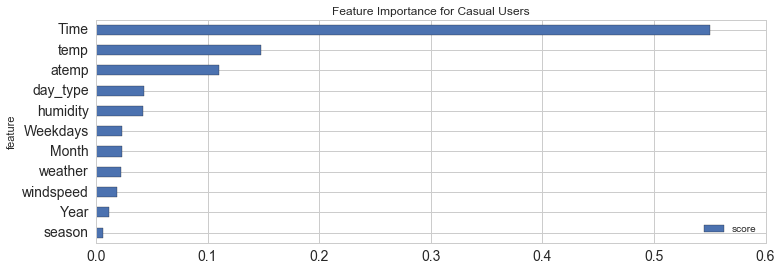

In [418]:
names = train_cas_X2.columns.values
feature_importance_cas =sorted(zip(map(lambda x: round(x, 4), rf_cas.feature_importances_), names), reverse=False)
feature_importance_cas = pd.DataFrame(feature_importance_cas,columns=['score','feature'])
feature_importance_cas.plot(kind='barh',x='feature',y='score',figsize =(12,4),title='Feature Importance for Casual Users',fontsize= 14)

## Conclusion

### Regression Model

1. Visually analysed  relationship between the various features and demand.
2. Based on the analysis through graphs, treated Time, Year, Month, Weekday, day_type, Temperature, season and weather as categorical variables due to their non linear relationship with demand.
3. Treated wind speed and humidity as continuous variables. 
4. Used Decision Tree for binning temperature values for casual user and registered user separately.
5. Formed two separate models for predicting casual and registered users demand.
6. As there were natural outliers, took log of registered user and casual user demand to build my model.
7. R square for registered user - .8178
8. R square for casual user - 0.81500  


### Random Forest Model

1. Random Forest method does not need separation of features into categorical and linear.
2. Developed separate models for registered user and casual user using Random Forest Regressor from sklearn.ensemble.
3. R square for registered user - 0.9449
4. R square for casual user - .85727
5. Using Random Forest Model for prediction has increased my R square.
6. Utilising the feature importance function of Random Forest, determined which feature has the most effect and which feature has the least affect on demand for casual users and registered users.